In [1]:
import pandas as pd
from icecream import ic
import seaborn as sns
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import powerlaw
import polars as pl
from fuzzywuzzy import fuzz
from tqdm import tqdm
import requests
import re
import json

## Collect character metadata
Firsly, collect a list of all characters which appear in the show, to be able to better find when a character in the GoT scripts speak.
Secondly, collect metadata about each characters house and affiliations from the GoT fandom wiki 

In [ ]:
def get_wiki_json(title, print_url=False):
    " Function to get the wikitext, based on character name"
    title = "_".join(title.split())
    url = f"https://gameofthrones.fandom.com/api.php?action=query&format=json&titles={title}&prop=revisions&rvprop=content&"
    if print_url==True:
        print('url:', url)
    reg = requests.get(url)
    return reg.text

def get_text_fromwiki(txt):
    "Function to get text from wiki json"
    # try except is there to cactc all errors from trying to get the text from the wiki cite
    # since some of the pages might not exsist
    try:
        js = json.loads(txt)
        key = js.get("query").get("pages").keys()
        key = list(key)[-1]
        out = js.get("query").get("pages").get(key).get("revisions")
        out = out[0].get("*")
        return out
    except :
        return ''

def extract_attr(attr):
    "Function to extract affiliation/house from text"
    # Extract Affiliation or House
    # Match everything from the attribute
    all_matches = re.search(attr + r'\s*=.+', wikitext)
    # split it from the newline
    # Then extract all links
    matches = list()
    if all_matches is not None:
        match = all_matches.group(0).split('\n')
        matches = re.findall(r'\[\[([^\|^\]]+)\|?[^\]]*\]\]', all_matches.group(0))
    # remove ward from list
    matches = [x for x in matches if x not in ['ward']]
    return matches

def GatherLinks(text): 
    "Function to get links"
    links = re.findall("\[\[[^\]]+\]\]", text)
    finalList = list()
    for link in links:
        finalList.append(link.strip("[[").strip("]]").split("|")[0])
    return(finalList)

def get_all_characters(EpisodeList, print_url=False):
    "Functioon to get all characters from each episode"
    with open(EpisodeList, 'r') as f:
        characters = set()
        for line in f:
            episode = line.strip()
            wikijson = get_wiki_json(episode, print_url=print_url)
            wikitext = get_text_fromwiki(wikijson)
            links = GatherLinks(wikitext)
            characters.update(links)
    characters = set(characters)
    return characters

# Get all characters from each describtion of the episodes in the show
# Since they include all new appearances
EpisodeList = '../data/EpisodeList.txt'
character_set = get_all_characters(EpisodeList, print_url=False)

## Get data for each character found
char_info = dict()
# Go through each character collect aboce
for i, character in enumerate(character_set):
    if re.match(r'[\w\s_]*', character) is not None:
        # Get the wiki json
        wikijson = get_wiki_json(character, print_url=False) 
        # Collect the text from it
        wikitext = get_text_fromwiki(wikijson)
        # Get the affiliations and house for the character
        affil = extract_attr('Affiliation')
        house = extract_attr('House')
        # save the information
        char_info[character] = [house, affil]
    else:
        pass
# Write the information to a file
df = pd.DataFrame.from_dict(char_info, orient='index')
df.to_csv('../data/characher_metadata.csv')


## Making the location data
At the momement we have information about what each location of each scene is, but it includes other information such that they cannot be matched. The goal here is to match them with locations only contain the names of the locations in the show

In [9]:
# Read in the scene_data
D = pd.read_csv('../data/scene_data')
D = pl.from_pandas(D)
# Read in the character metadata and use it to 
# make a list of all characters
metadata = pd.read_csv('../data/characher_metadata2.csv')
metadata_name = list(metadata.iloc[:,0])
metadata_name = set([name.lower() for name in metadata_name])
# Remove a few wierd additions which should not be in the metadata
metadata_name.remove('horse')
metadata_name.remove('file:the riverlands.png')
metadata_name.remove('de:winterfell')
metadata_name.remove('the prince of winterfell')
metadata_name.remove("king's landing rioter") # could be several characters
metadata_name.remove("riverlands") # "the riverlands" is allready in the data
metadata_name.remove("iron throne") # "the ironthrone" is allready in the data
# Add list of costum locations which should be compared against. 
locations = []
with open('../data/manual_annotated_locations.csv', "r") as f:
    for line in f:
        locations.append(line.strip())
#Set locations to lower-case
locationsset = set([x.lower() for x in locations])

The goal of the next part is to 1) fuzzy match the scenelocations mentioned for each location with names from an annotated list and with location names from the GoT fandom wiki, which is avalible along with the information about all characters from parsing the GoT fandom wiki. If none match the method also checks if the exact location is in the scene costum location list.

In [14]:
# Make empty column
D=D.with_columns(pl.lit(None).alias('scene_locations'))
# Make list of unique scenes
unique_scenes = D['Scene'].unique()
# Go through each scene
for scene in tqdm(unique_scenes):
    final_rename = None
    og_scene = scene
    scene = scene.lower()
    # Remove unique identifier
    scene = scene.split('_')[0:-1]
    scene =''.join(scene)
    # Remove specific location ie. winterfell – courtyard  or essos, outside yunkai
    if '–' in scene:
        scene = scene.split('–')[0]
        scene =''.join(scene)
    if '-' in scene:
        scene = scene.split('-')[0]
        scene =''.join(scene)
    if ',' in scene:
        scene = scene.split(',')[0]
        scene =''.join(scene)

    # calculate fuz ratio for each location - scene pair. 
    # pick the highest ratio if above threshold
    max_fuzzy_ratio = [0, None, None]
    for name in metadata_name:
        fuzzy_ratio = fuzz.token_sort_ratio(scene, name)
        if fuzzy_ratio > max_fuzzy_ratio[0]:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = name
    threshold = 80
    if max_fuzzy_ratio[0] > threshold:
        final_rename = max_fuzzy_ratio
        
    # Now also check pure locations as seen in location vector and take the best of them if they have a good match
    max_fuzzy_ratio = [0, None, None]
    for name in locations:
        fuzzy_ratio = fuzz.token_sort_ratio(scene, name)
        if fuzzy_ratio > max_fuzzy_ratio[0]:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = name
    threshold = 80
    if max_fuzzy_ratio[0] > threshold:
        final_rename = max_fuzzy_ratio
        
    # Lastly check if any has the eact location in if none found yet
    if final_rename is None:
        add = False
        to_add = None
        for location in locationsset:
            found = scene.find(location)
            if found != -1:
                add = True
                to_add = location
        if add:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = to_add   
            final_rename = max_fuzzy_ratio

    # If found a clear location name, then add it to the dataframe.
    if final_rename is not None:
        D = D.with_columns(pl.when(pl.col('Scene') == final_rename[1])
                        .then(pl.lit(final_rename[2].lower()))
                        .otherwise(pl.col('scene_locations'))
                        .alias('scene_locations')
                          )
# Read to csv
D.to_pandas().to_csv('../data/scene_data_with_location.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:47<00:00, 32.69it/s]


## Plotting the number of lines spoken by each character
#### (did not make it, to the report)

In [36]:
# Read data from csv
D = pd.read_csv('../data/scene_data_with_location.csv')
D = pl.from_pandas(D)
# Filter out null for scene_locations
D_not_null = D.filter(
    pl.col('scene_locations').is_not_null()
    )

In [20]:
## Define plot 
def plot_scene_lines(D_not_null, to_plot, to_compare, threshold, ylab):
    from plotnine import ggplot, geom_density, aes, facet_wrap, labs, theme, geom_histogram
    from plotnine.coords import coord_flip
    from plotnine.mapping import after_stat
    from plotnine.themes import theme_minimal
    import numpy as np

    # calculate the number of lines/scenes for each locations
    Dpd = (D_not_null
         .group_by(pl.col(to_compare))
         .agg(pl.col(to_plot).count().alias('number_lines_locations'),  
              pl.col(to_plot).first(), 
              pl.col('SeasonNr').first())
         .to_pandas()
     )
    Dpd['rowcount'] = Dpd.groupby(by=[to_plot])['number_lines_locations'].transform('count')
    
    # apply cutoff depending on threshold
    Dpd = Dpd[Dpd.rowcount > threshold]

    # Make the plot
    plot_final=(ggplot(Dpd, aes(x='SeasonNr',color=to_plot, fill=to_plot))
        + geom_density(aes(y=after_stat('count')), alpha=0.5)
        + facet_wrap('~'+to_plot)
        + labs(x='Season Number',color=to_plot, fill=to_plot, y=ylab)
        + theme_minimal()
        + theme(legend_position='none',)
    )
    return plot_final

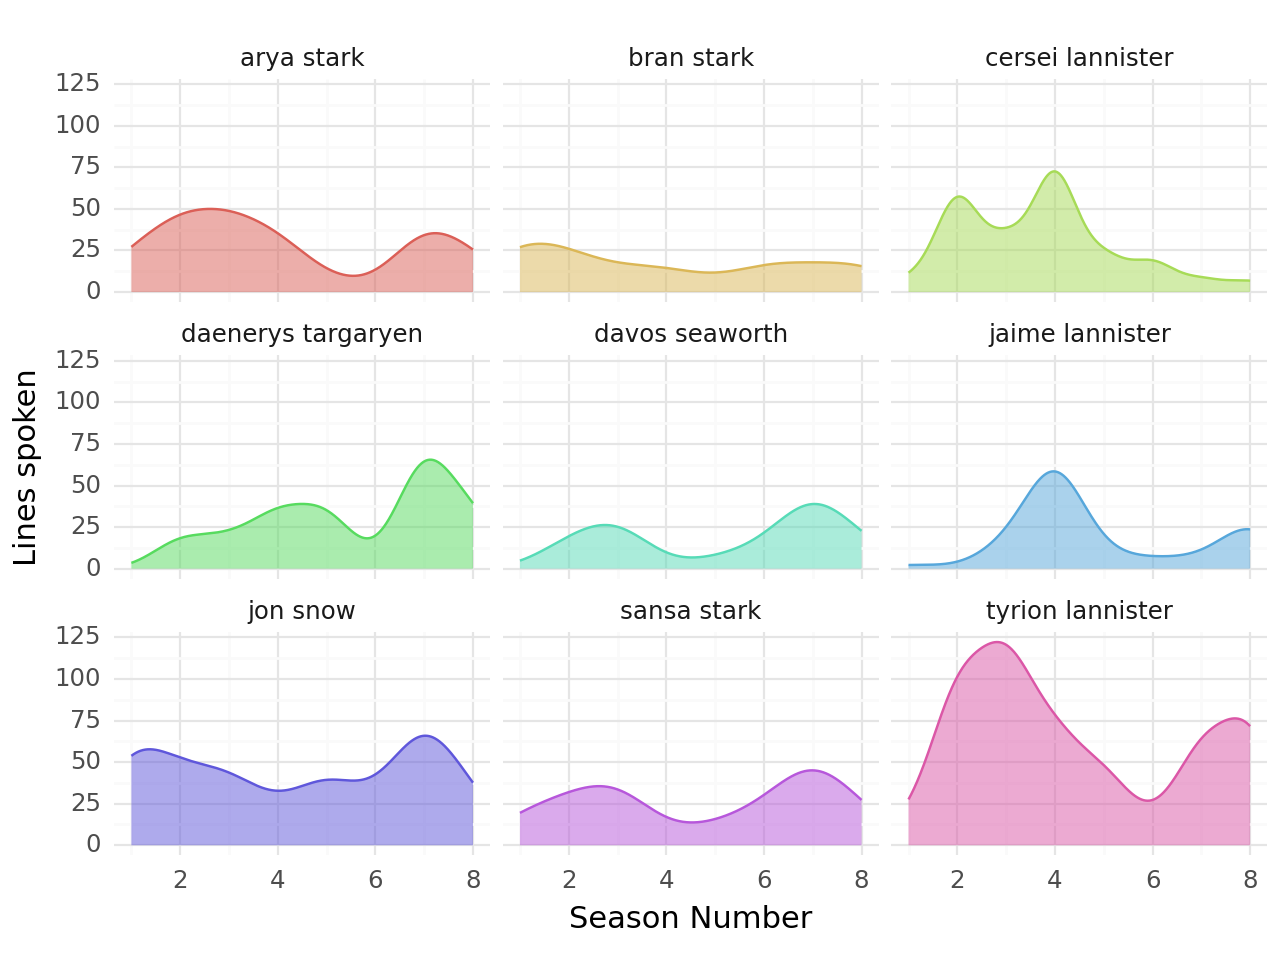

<Figure Size: (640 x 480)>

In [24]:
# Plot the number of lines spoken for each character with over 150 lines spoken
to_plot = 'Person'
to_compare = 'ScreenLine'
# Entries with above threshold to show
threshold = 150
plot_scene_lines(D_not_null, to_plot, to_compare, threshold, 'Lines spoken')

## Calculate the degree distribution for the in- and out- degrees combined 

In [2]:
# Read in the network
file = open('GOTNetwork.pkl', "rb")
G = pickle.load(file)
# Extract the degree distribution
degree_sequence = [d for n, d in G.degree()]
# Fit a power law to the network
powerlaw.Fit(degree_sequence).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


2.6120461668304276

## Degree distribution for the weighted in- and out-degrees

In [3]:
# Define a function to get all the lines from the network metadata
def get_lines(node):
    out = []
    for x in node[2]['lines'].values():
        for x in x.values():
            for x in x.values():
                for x in x.values():
                    out += x
    return out

# Create a list in which to add all the metadata w.r.t. lines spoken from the network
edges = list()
x=0
# Go thorugh each edge and add the metadata
for edge in list(G.edges(data=True)):
    to_add = dict()
    from_node = edge[0]
    to_node = edge[1]
    lines = get_lines(edge)
    
    to_add['from_node'] = from_node
    to_add['to_node'] = to_node

    # Make sure not to count the number of chars if lines is not a list
    if isinstance(lines, list):
        to_add['n_lines'] = len(lines)
    else:
        to_add['n_lines'] = 1
    edges += [to_add]
# Read the data into a dataframe
df = pd.DataFrame.from_dict(edges)

In [4]:
# Extract the in-and out degree's from the above defined dataframe
indegrees = df.groupby('to_node').agg(indegree = ('n_lines','sum'))['indegree'].to_numpy()
outdegrees = df.groupby('from_node').agg(outdegree = ('n_lines','sum'))['outdegree'].to_numpy()
# Fit a powerlaw to the weighted indegrees
powerlaw.Fit(indegrees).alpha
# Fit a powerlaw to the weighted outdegrees
powerlaw.Fit(outdegrees).alpha

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


2.824122678347856

#### Making table 1, weighted in and out degrees

In [5]:
# Print a list of the nodes with the highest weighted out- and in- degrees
indegrees = df.groupby('to_node').agg(indegree = ('n_lines','sum'))['indegree']
outdegrees = df.groupby('from_node').agg(outdegree = ('n_lines','sum'))['outdegree']
print('##### weighted out degree #####')
print(outdegrees.sort_values(ascending=False).iloc[0:6])
print('##### weighted in degree #####')
print(indegrees.sort_values(ascending=False).iloc[0:6])

##### weighted out degree #####
from_node
tyrion lannister      4739
jon snow              3432
daenerys targaryen    2811
cersei lannister      2367
jaime lannister       2015
sansa stark           1925
Name: outdegree, dtype: int64
##### weighted in degree #####
to_node
tyrion lannister      2917
jon snow              2356
sansa stark           1904
jaime lannister       1824
cersei lannister      1708
daenerys targaryen    1674
Name: indegree, dtype: int64


## Community analysis

In [14]:
# Read in the data
D = pd.read_csv('../data/scene_data_with_location.csv')
# Read in the network again
file = open('GOTNetwork.pkl', "rb")
G = pickle.load(file)
# Set a random seed for reproduciblity
np.random.seed(42)

# Define function to add the weight (the number of lines spoken) to the network
def edgeWeights_(Graph):
    edgeweights = list()
    colourList = list()
    for (FROM, TO, attributes) in Graph.edges(data=True):
        lineSum = 0
        for season,value in attributes["lines"].items():
            for episode, value2 in value.items():
                for episodename,value3 in value2.items():
                    lineSum += len(value3.keys())
        Graph[FROM][TO]["weight"] = lineSum
# apply the function
edgeWeights_(G)

To be able to compare partitions across seasons, partition the network into seasons

In [15]:
SeasonNodesList = list()
EdgeList = list()
# Partition the network into seasons 
for i in range(0,8):
    SeasonNodesList.append(set())
    EdgeList.append(list())
    for FROM, TO in G.edges():
        if i+1 in G.edges[FROM,TO]["lines"].keys():
            SeasonNodesList[i].add(FROM)
            SeasonNodesList[i].add(TO)
            EdgeList[i].append((FROM,TO))
FinalSeasonNodesList = [list(x) for x in SeasonNodesList]
EdgeSubGraphs = [G.edge_subgraph(x) for x in EdgeList]
NodeSubGraphs = [G.subgraph(x) for x in FinalSeasonNodesList]

The next step is to compare the partition of the network using the lovain community algorithm, to the partition using the houses. As some characters have several houses, a random house is added to each. This is repeated a 100 times for each season using the seed 1-100 for reproducibility. The modularity of the partitons are saved

In [16]:
# define vectors to save the output values
pl = []
pmax = []
# Repeat a 100 times
for j in range(100):
    # set the seed
    np.random.seed(j)
    pl.append([])
    pmax.append([])
    # Go through each subgraph from each season 
    for i in range(len(NodeSubGraphs)):
        # Select the correct partition
        Gsub = NodeSubGraphs[i]
        nodes = list(Gsub.nodes)
        perhos = [(per,hous) for per, hous in zip(D.Person, D.House) if per in nodes]
        
        # Make a set for each house to be able to later partition them
        per_hos = {person.lower().strip():house.split(',') for person, house in perhos if isinstance(house, str)}
        hos_per = dict()
        for person, houses in per_hos.items():
            # Select a random house
            random_house = np.random.choice(houses)
            random_house = random_house.lower().strip()
            person = person.strip().lower()
            if random_house in hos_per:
                hos_per[random_house] += [person]
            else:
                hos_per[random_house] = [person]            
        house_comm = [set(x) for x in hos_per.values()]
        
        # Remove nodes from network without a house
        Gsubsub = nx.Graph(Gsub)
        for person, house in perhos:
            if pd.isna(house):
                try:
                    Gsubsub.remove_node(person)
                except nx.NetworkXError as e:
                    pass

        # reformat the data and append the calculated modularity
        [[j for j in x] for x in house_comm]
        pl[j].append(nx.community.modularity(Gsubsub, house_comm))
        # apply the lovain community algorithm and save the output
        max_comm = nx.community.louvain_communities(Gsubsub, weight='weight')
        pmax[j].append(nx.community.modularity(Gsubsub, max_comm))

Now the same approach is repeated for the affiliations for each characters

In [22]:
# vector to save the output values
paff = []
# Repeat 100 times
for j in range(100):
    # Set seed
    np.random.seed(j)
    paff.append([])
    #Go through each season
    for i in range(len(NodeSubGraphs)):
        # select the correct partition
        Gsub = NodeSubGraphs[i]
        nodes = list(Gsub.nodes)  
        perhos = [(per,affil) for per, affil in zip(D.Person, D.Affiliations) if per in nodes]
        
        # Make a set for each affiliaton
        affil_hos = {person.lower().strip():affiliation.split(',') for person, affiliation in perhos if isinstance(affiliation, str)}
        affil_per = dict()
        for person, affiliations in affil_hos.items():
            # Select a random affiliation
            random_affiliation = np.random.choice(affiliations)
            random_affiliation = random_affiliation.lower().strip()
            person = person.strip().lower()
            if random_affiliation in affil_per:
                affil_per[random_affiliation] += [person]
            else:
                affil_per[random_affiliation] = [person]            
        affiliation_comm = [set(x) for x in affil_per.values()]
        
       # Remove nodes from the network without an affiliation 
        Gsubsub = nx.Graph(Gsub)
        for person, affiliation in perhos:
            if pd.isna(affiliation):
                try:
                    Gsubsub.remove_node(person)
                except nx.NetworkXError as e:
                    pass

        # reformat the data and append the calculated modularity
        [[j for j in x] for x in affiliation_comm]
        paff[j].append(nx.community.modularity(Gsubsub, affiliation_comm))

##### Making figure 5. Sentiment for different partitions for each season

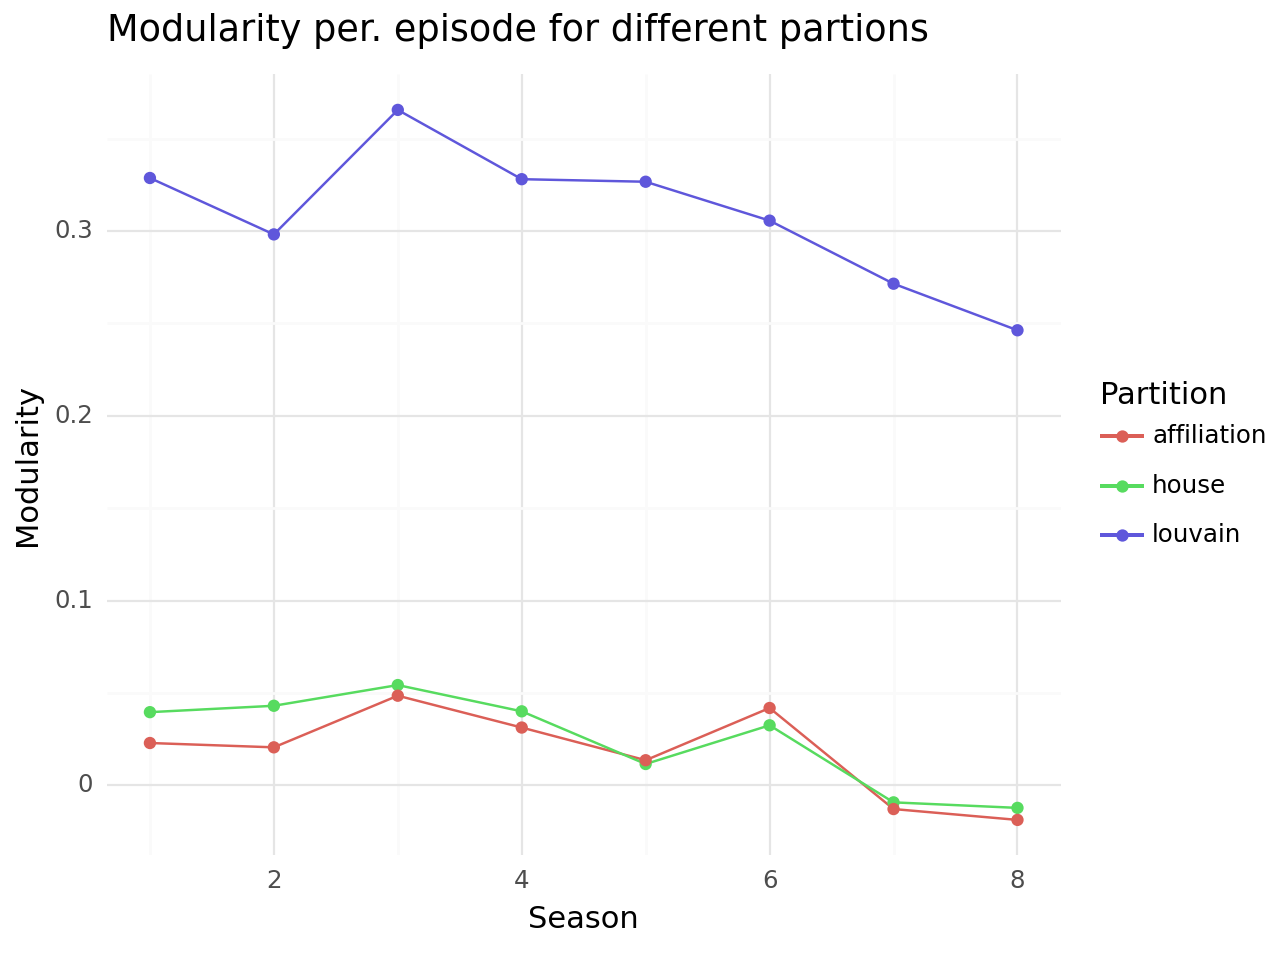

<Figure Size: (640 x 480)>

In [23]:
# calculate the mean of each repetition
x = list(np.sum(pl, axis=0)/100) + list(np.sum(paff, axis=0)/100) + list(np.sum(pmax, axis=0)/100)
# Assign the data to a dataframe
col = ['house']*8  +  ['affiliation']*8 +  ['louvain']*8 
d = pd.DataFrame()
d['data'] = x
d['type'] = col
d['123'] = list(range(1,8+1)) + list(range(1,8+1)) + list(range(1,8+1))

# Make the plot
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal
(
ggplot(d, aes(y='data', x='123', color='type')) 
 + geom_line() + geom_point() + labs(x='Season', y='Modularity', color='Partition', title='Modularity per. episode for different partions')
    + theme_minimal()
)